In [1]:
import torch
import sys
sys.path.append("../")
import cumulant_analyzer
from cumulant_analyzer import CumulantAnalyzer, to_numpy
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import plot_utils
from plot_utils import plot_comparison, plot_stats
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings(
    "ignore",
    message="You are using `torch.load` with `weights_only=False`.*",
    category=FutureWarning,
)

from transformers.utils.logging import disable_progress_bar
disable_progress_bar()

g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
ds = load_dataset("NeelNanda/pile-10k")['train']
filtered_indices = np.load('filtered_indices.npy')
max_length = 256

In [3]:
model_names = ['gpt2', 'gpt2-large', 'gpt2-xl'] 
analyzers = {}
for model_name in model_names:
    analyzers[model_name] = CumulantAnalyzer(model_name=model_name, max_length = 256)

In [4]:
test_indx = np.random.choice(2244)
prompt_indx = filtered_indices[test_indx]
test_sequence = ds['text'][prompt_indx].strip()
stats = {}
for model_name in model_names:
    stats[model_name] = analyzers[model_name].compute_stats(test_sequence)
    s = stats[model_name]
    stats[model_name]['new_stats'] = np.concatenate([np.expand_dims(s['avg_entropy'], 1), np.expand_dims(s['entropy_com'],1), s['avg_normalized_cumulants']], axis = 1)

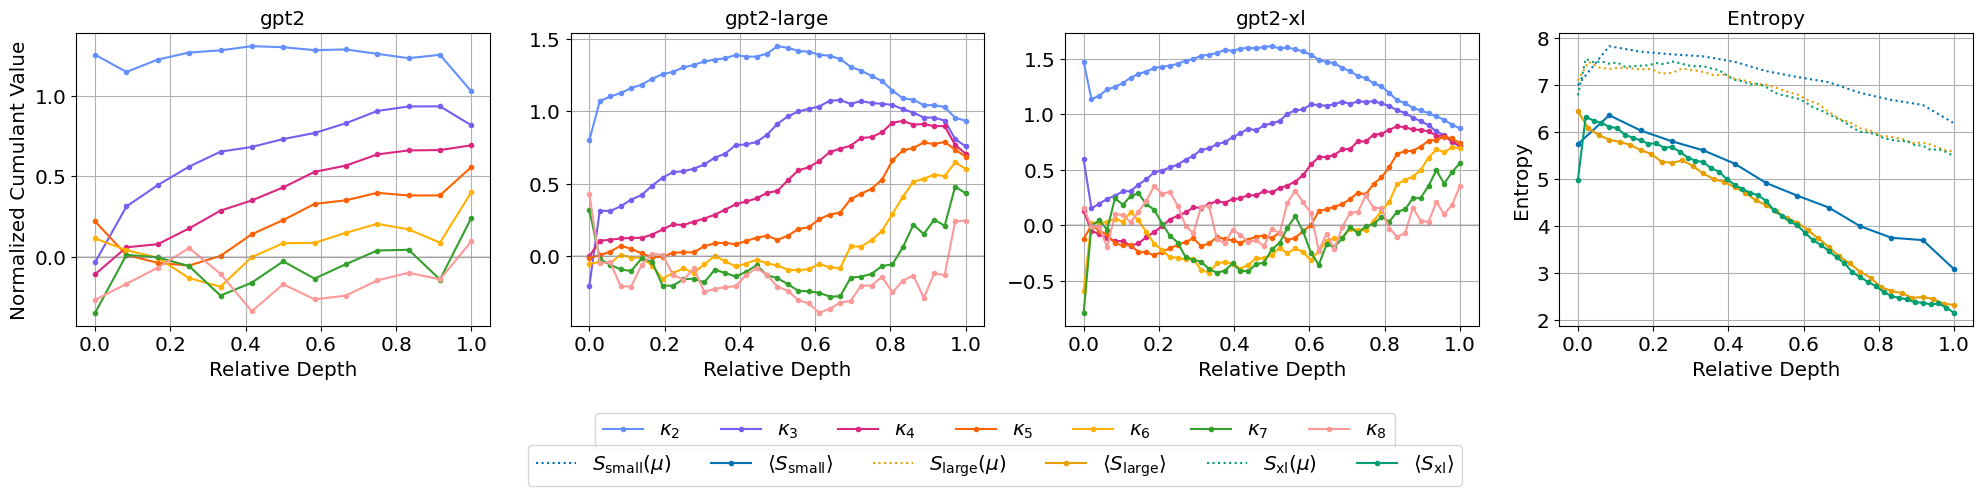

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    
# Panel 1: Structured cumulants
for idx, model_name in enumerate(model_names):
    plot_stats(stats[model_name], axes[idx], title = model_name)
    if idx > 0: axes[idx].set_ylabel(None)

# Panel 2: Shuffled cumulants
# Panel 3: Entropy using blue and orange
ax_entropy = axes[3]
blue = "#0072B2"    
orange = "#E69F00"  
green = "#009E73" 

label_map = {
    'gpt2':         (r"$S_{\mathrm{small}}(\mu)$", r"$\langle S_{\mathrm{small}} \rangle$"),
    'gpt2-large':   (r"$S_{\mathrm{large}}(\mu)$", r"$\langle S_{\mathrm{large}} \rangle$"),
    'gpt2-xl':      (r"$S_{\mathrm{xl}}(\mu)$", r"$\langle S_{\mathrm{xl}} \rangle$")
}

color = {'gpt2':blue, 'gpt2-large':orange, 'gpt2-xl':green}
for model_name in model_names:
    s = stats[model_name]
    num_entries = s['entropy_com'].shape[0]
    label_mu, label_avg = label_map[model_name]
    ax_entropy.plot(
        np.linspace(0, 1, num_entries),
        s['entropy_com'],
        linestyle='dotted',
        color=color[model_name],
        label=label_mu
    )
    ax_entropy.plot(
        np.linspace(0, 1, num_entries),
        s['avg_entropy'],
        marker='.',
        color=color[model_name],
        label=label_avg
    )


ax_entropy.set_title("Entropy", fontsize = "x-large")
ax_entropy.grid(True)
ax_entropy.set_xlabel('Relative Depth', fontsize = "x-large")
ax_entropy.set_ylabel('Entropy', fontsize = "x-large")
# ax_entropy.legend(loc='best', fontsize = "large")

ax_entropy.tick_params(which='both', labelsize="x-large")

# Collect handles and labels separately for shuffled/structured cumulants and entropy
handles_labels_0 = axes[0].get_legend_handles_labels()  # Structured cumulants
handles_labels_2 = axes[3].get_legend_handles_labels()  # Entropy

# Legend line 1: Cumulants
fig.legend(
    handles_labels_0[0],
    handles_labels_0[1],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.02),  # Line 1
    ncol=len(handles_labels_0[0]),
    fontsize="x-large"
)

# Legend line 2: Entropy
fig.legend(
    handles_labels_2[0],
    handles_labels_2[1],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.10),  # Line 2 (lower than line 1)
    ncol=len(handles_labels_2[0]),
    fontsize="x-large"
)

# Adjust layout
plt.tight_layout()
plt.savefig(f'../plots/different_model_sizes.png', bbox_inches='tight')
plt.show()   